In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


import os
import numpy as np
import matplotlib.pyplot as plt

2024-11-06 09:27:52.707507: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 09:27:52.843463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 09:27:52.894849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 09:27:52.910341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 09:27:53.014288: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-11-06 09:28:11--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 2606:4700:20::681a:221, 2606:4700:20::ac43:4695, 2606:4700:20::681a:321, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|2606:4700:20::681a:221|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   980KB/s    in 59s     

2024-11-06 09:29:11 (1.14 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
   creating: cats_and_dogs/
  inflating: cats_and_dogs/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cats_and_dogs/
  inflating: __MACOSX/cats_and_dogs/._.DS_Store  
   creating: cats_and_dogs/test/
  inflating: cats_and_dogs/test/48.jpg  
   creating: __MACOSX/cats_and_dogs/test/
  inf

In [4]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values from [0, 255] to [0, 1]
    rotation_range=40,           # Randomly rotate images
    width_shift_range=0.2,       # Randomly shift images horizontally
    height_shift_range=0.2,      # Randomly shift images vertically
    shear_range=0.2,             # Randomly shear images
    zoom_range=0.2,              # Randomly zoom into images
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill in new pixels after a transformation
)

validation_image_generator = ImageDataGenerator(rescale=1./255)

test_image_generator = ImageDataGenerator(rescale=1./255)

# Load images from directory and apply transformations
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'  # Since this is a binary classification problem (cats and dogs)
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

test_data_gen = test_image_generator.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


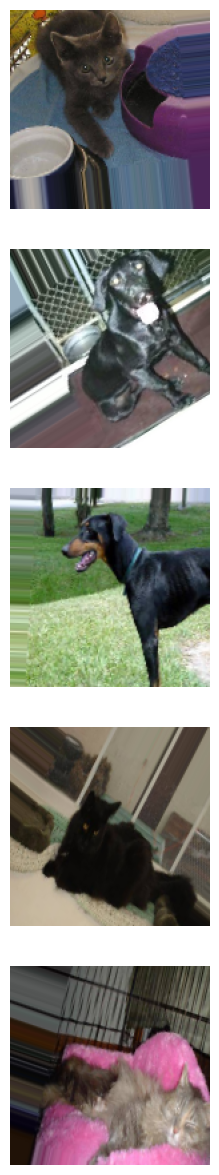

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values
    rotation_range=40,           # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by 20% of the width
    height_shift_range=0.2,      # Randomly shift images vertically by 20% of the height
    shear_range=0.2,             # Shear the image (slanting the image)
    zoom_range=0.2,              # Randomly zoom in by 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Fill missing pixels after transformations
)




Found 2000 images belonging to 2 classes.


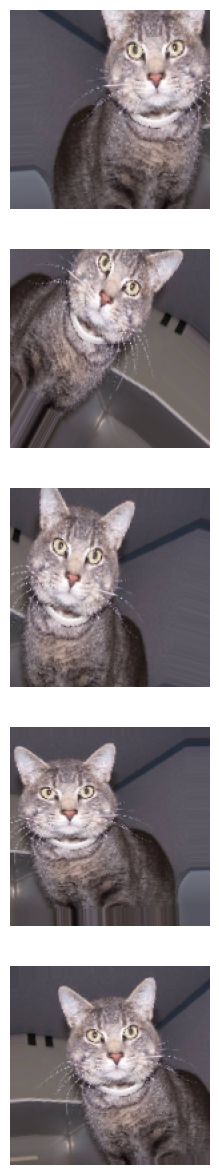

In [7]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout for regularization to prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification: "cat" or "dog"
])
model.compile(optimizer='adam',  # Adam optimizer is a good choice for most cases
              loss='binary_crossentropy',  # Loss function for binary classification
              metrics=['accuracy'])
model.summary()

/home/stonie/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1730874737.111962   11919 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730874737.213721   11919 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730874737.213959   11919 cuda

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
from PIL import Image

In [10]:
# Calculate steps per epoch and validation steps
from keras.callbacks import EarlyStopping

steps_per_epoch = total_train // batch_size
validation_steps = total_val // batch_size
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=50,
    validation_data=val_data_gen,
    validation_steps=validation_steps // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 331ms/step - accuracy: 0.6789 - loss: 0.5931 - val_accuracy: 0.7270 - val_loss: 0.5593
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7031 - loss: 0.5570 - val_accuracy: 0.6990 - val_loss: 0.5755
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step - accuracy: 0.6948 - loss: 0.5894 - val_accuracy: 0.7180 - val_loss: 0.5457
Epoch 4/50
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7344 - loss: 0.5247

2024-11-06 09:49:23.177739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11547573704191552975
2024-11-06 09:49:23.177772: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3740971907234583672


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7344 - loss: 0.5247 - val_accuracy: 0.7180 - val_loss: 0.5524
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 329ms/step - accuracy: 0.7108 - loss: 0.5596 - val_accuracy: 0.7000 - val_loss: 0.5421
Epoch 6/50
 1/15 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6875 - loss: 0.5804

2024-11-06 09:49:31.997477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3740971907234583672


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.6875 - loss: 0.5804 - val_accuracy: 0.7140 - val_loss: 0.5321


ValueError: x and y must have same first dimension, but have shapes (15,) and (13,)

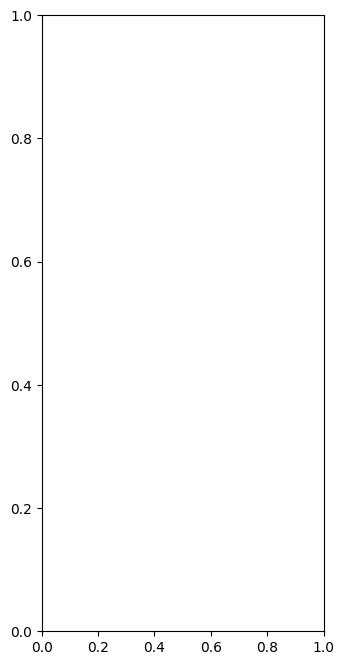

In [37]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
# Load all images from the test directory into a list
test_images = []
for img in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img)
    
    # Check for valid image extensions
    if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
        try:
            img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
            test_images.append(img_array)
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")

# Convert list to a NumPy array if there are any valid images
if test_images:
    test_images = np.vstack(test_images)  # Stack all images into one array

    # Rescale images using the ImageDataGenerator
    test_image_generator = ImageDataGenerator(rescale=1./255)

    # Create a data generator using the `flow` method
    test_data_gen = test_image_generator.flow(
        test_images,
        batch_size=batch_size,
        shuffle=False  # Do not shuffle so predictions match the order of the images
    )

    # Now you can use this generator to predict
    probabilities = model.predict(test_data_gen)
    print(probabilities)
else:
    print("No valid images found in the test directory.")




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
[[0.3679666 ]
 [0.70314556]
 [0.8682441 ]
 [0.59335977]
 [0.32748494]
 [0.628765  ]
 [0.9177957 ]
 [0.35236856]
 [0.41606346]
 [0.7410961 ]
 [0.2361955 ]
 [0.46149948]
 [0.40621722]
 [0.66646385]
 [0.6458428 ]
 [0.5475417 ]
 [0.5593468 ]
 [0.47283408]
 [0.28624722]
 [0.5684748 ]
 [0.5446995 ]
 [0.8746228 ]
 [0.30541378]
 [0.60680884]
 [0.9786324 ]
 [0.99754804]
 [0.5649502 ]
 [0.29018825]
 [0.64408046]
 [0.66038555]
 [0.26947945]
 [0.58309865]
 [0.22301854]
 [0.16174413]
 [0.8407235 ]
 [0.5141831 ]
 [0.44616193]
 [0.5770303 ]
 [0.4845101 ]
 [0.4409117 ]
 [0.66513205]
 [0.20952994]
 [0.77760834]
 [0.7211512 ]
 [0.46628413]
 [0.5234699 ]
 [0.28556713]
 [0.37589517]
 [0.7873432 ]
 [0.65300566]]


In [13]:
# Assuming `probabilities` are the output from your model prediction in the previous cell.

answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

# Ensure the probabilities are flattened if needed
if len(probabilities.shape) > 1:
    probabilities = probabilities.flatten()  # Flatten the predictions

for probability, answer in zip(probabilities, answers):
    if round(probability) == answer:
        correct += 1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 54.0% of the images of cats and dogs.
You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!
